In [1]:
# uncomment if needed

#Source for code inspiration: https://www.codemag.com/Article/2205081/Implementing-Face-Recognition-Using-Deep-Learning-and-Support-Vector-Machines

%pip install keras_vggface
%pip install keras_applications
%pip install opencv-python
%pip install tensorflow
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
keras.__version__

'2.10.0'

### Pull VGGFace ResNet50 Pretrained Weights 

ResNet50 is trained on VGGFace2 Dataset

In [3]:
from keras_vggface.vggface import VGGFace

# keras.engine.topology deprecated -- need to replace source code
filepath = "/Users/chloegriffin/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras_vggface/models.py" # replace filepath as necessary! 
text = open(filepath).read()
open(filepath, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

model = VGGFace(model='resnet50')

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-07 12:40:57.196500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 12:40:57.196598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Begin Transfer Learning!

We reuse the feature extraction of images thanks to the ResNet50 pretrained model weights, but retrain the classifier on six new faces of characters from _The Office_: 
- Angela 
- Dwight
- Jim 
- Kevin
- Michael
- Pam

Notice that by adding in more folders of character faces, we can easily extend this to more than just these main six characters. 

### Preprocessing Training Images

We want to extract the faces (i.e. zoom/crop to only faces) so that only the faces are used for training. That is, 
1. Iterate through all the images in the folders and extract the face in the image using OpenCV's Haar cascade.
2. Resize the extracted face to the size required by VGGFace16: 224x224 pixels.
3. Replace the original image with the extracted face.


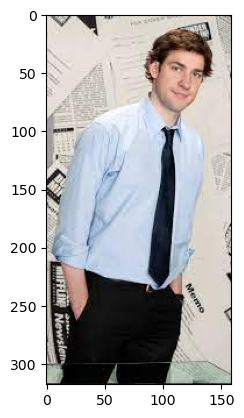

In [4]:
import cv2
import os
import shutil
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

headshots_folder_name = '../Data/characters/train'

img = Image.open('../Data/characters/train/Jim/0 10.22.12 AM.png')
im_array = np.asarray(img)
plt.imshow(img)
plt.show()


../Data/Zoomed_Faces/Jim/312 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/180 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/281 10.22.12 AM.png
---Photo skipped---

../Data/Zoomed_Faces/Jim/66 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/203 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/178 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/298 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/42 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/38 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/188.png
../Data/Zoomed_Faces/Jim/102 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/279 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/177 10.22.12 AM.png
---Photo skipped---

../Data/Zoomed_Faces/Jim/196 10.22.12 AM.png
---Photo skipped---

../Data/Zoomed_Faces/Jim/91 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/304 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/37 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/88 10.22.12 AM.png
---Photo skipped---

../Data/Zoomed_Faces/Jim/114 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/3 10.22.12 AM.png
../Data/Zoomed_Faces/Jim/13 10.22.12

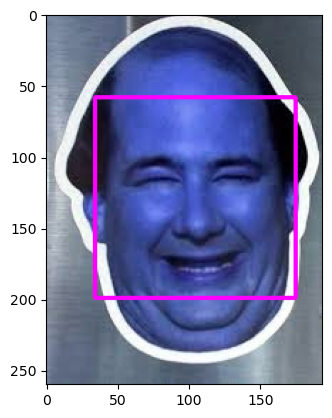

In [5]:
# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)

# create new directory for storing Zoomed images
zoom_path = '../Data/Zoomed_Faces'#

#Ensures creating new folder with Zoomed from path
if os.path.exists(zoom_path):
    shutil. rmtree(zoom_path)

shutil.copytree(images_dir,
                zoom_path)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(zoom_path):
    for file in files:

        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
        # path of the image
        # print(path)
            path = os.path.join(root, file)
            print(path)
        else:
            continue



        label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest,
            scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
            # remove the original image
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            plt.imshow(face_detect)
            # plt.show() 

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove original folder from new path
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            
            im.save(path)


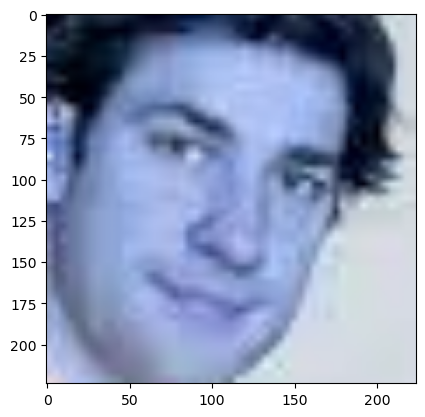

In [6]:
img = Image.open('../Data/Zoomed_Faces/Jim/0 10.22.12 AM.png')
im_array = np.asarray(img)
plt.imshow(img)
plt.show()

### Import Libraries

In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

### Augment Training Data

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

#Ensures creating new folder with Zoomed from path
if os.path.exists(zoom_path):
    shutil. rmtree(zoom_path)

shutil.copytree(images_dir,
                zoom_path)

train_generator = train_datagen.flow_from_directory(
    zoom_path, 
    target_size=(224,224), 
    color_mode='rgb', 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)

print(train_generator)

Found 1061 images belonging to 6 classes.


In [9]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])

dict_values([0, 1, 2, 3, 4, 5])

In [10]:
NO_CLASSES = len(train_generator.class_indices.values())
print("The number of classes is", 6)

The number of classes is 6


### Build the Model

In [11]:
base_model = VGGFace(
    include_top=False,
    model='vgg16',
    input_shape=(224, 224, 3)
)

#Make base not trainable
base_model.trainable = False

base_model.summary()
print(len(base_model.layers))
# 174 layers after excluding the last few layers




Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [12]:
#Skipping this one

#x = base_model.output
#inputs = keras.Input(shape=(224, 224, 3))
#x = base_model.outputs
#x = GlobalAveragePooling2D()(x)

#x = Dense(1024, activation='relu')(x)
#x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='relu')(x)

# final layer with softmax activation
#preds = Dense(NO_CLASSES, activation='softmax')(x)

#model = keras.Model(x, outputs)

#model.summary()
#print(len(model.layers))

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [13]:
model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(), 
    Dense(1024, activation='relu'), 
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    # final layer with softmax activation
    Dense(NO_CLASSES, activation='softmax') 
])

In [14]:
# don't train the first 174 layers - 0..173
#for layer in model.layers[:19]:
 #   layer.trainable = False

# train the rest of the layers - 174 onwards
#for layer in model.layers[19:]:
 #   layer.trainable = True

#model.layers[1:19] = False
#model.layers[20:end] = True

model.summary()
print(len(model.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                        

### Compile and Train the Model

In [15]:
model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
model.fit(train_generator,
  batch_size = 50,
  verbose = 1,
  epochs = 20)

Epoch 1/20


2022-12-07 12:41:23.067176: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 12:41:23.299391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 13s 358ms/step - loss: 1.6378 - accuracy: 0.3214
Epoch 2/20
34/34 [==============================] - 12s 354ms/step - loss: 1.3107 - accuracy: 0.4967
Epoch 3/20
34/34 [==============================] - 12s 356ms/step - loss: 1.0256 - accuracy: 0.6117
Epoch 4/20
34/34 [==============================] - 12s 350ms/step - loss: 0.8749 - accuracy: 0.6843
Epoch 5/20
34/34 [==============================] - 12s 361ms/step - loss: 0.8031 - accuracy: 0.7050
Epoch 6/20
34/34 [==============================] - 12s 358ms/step - loss: 0.6754 - accuracy: 0.7568
Epoch 7/20
34/34 [==============================] - 12s 350ms/step - loss: 0.5882 - accuracy: 0.7776
Epoch 8/20
34/34 [==============================] - 12s 347ms/step - loss: 0.4902 - accuracy: 0.8162
Epoch 9/20
34/34 [==============================] - 12s 348ms/step - loss: 0.4004 - accuracy: 0.8473
Epoch 10/20
34/34 [==============================] - 12s 347ms/step - loss: 0.2868 - accuracy: 0.9114


### Saving the Model

In [17]:
# creates a HDF5 file
model.save(
    'transfer_learning_trained' +
    '_the_office_cnn_model.h5')

In [18]:
from tensorflow.keras.models import load_model

# deletes the existing model
del model

# returns a compiled model identical to the previous one
model = load_model(
    'transfer_learning_trained' +
    '_the_office_cnn_model.h5')

In [19]:
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)

# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

{0: 'Angela', 1: 'Dwight', 2: 'Jim', 3: 'Kevin', 4: 'Michael', 5: 'Pam'}


### Testing the Model

In [20]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as \
    f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)

['Angela', 'Dwight', 'Jim', 'Kevin', 'Michael', 'Pam']


../Data/characters/train/Jim/180 10.22.12 AM.png


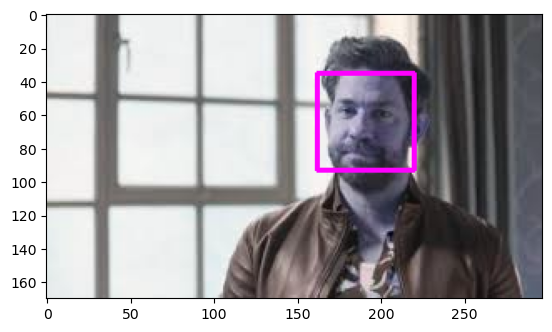

1/1 [==============================] - 0s 139ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/281 10.22.12 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Jim/66 10.22.12 AM.png


2022-12-07 12:45:24.391908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


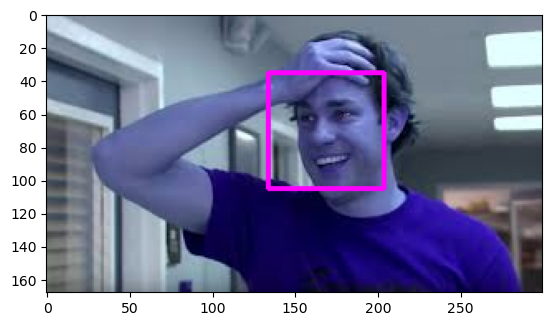

1/1 [==============================] - 0s 21ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/203 10.22.12 AM.png


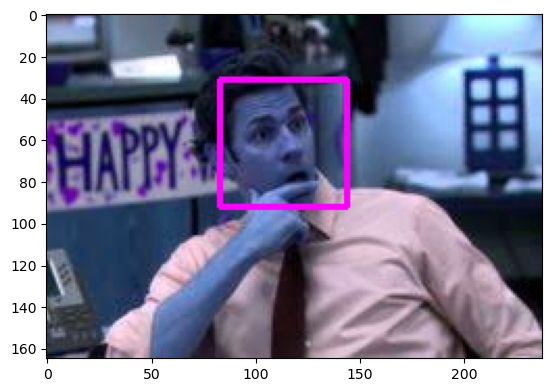

1/1 [==============================] - 0s 12ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/178 10.22.12 AM.png


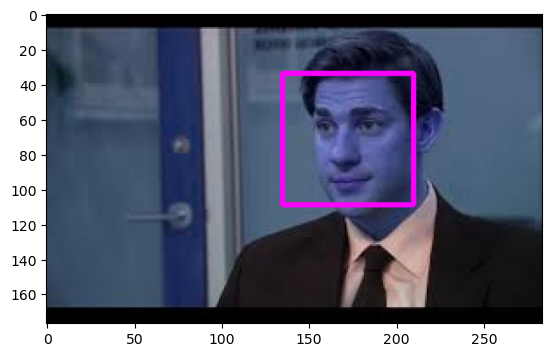

1/1 [==============================] - 0s 12ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/298 10.22.12 AM.png


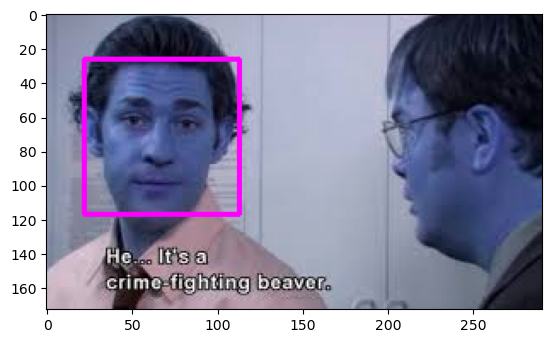

1/1 [==============================] - 0s 12ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/42 10.22.12 AM.png


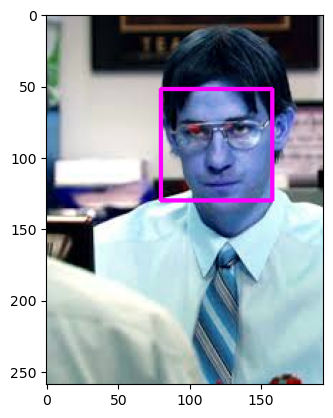

1/1 [==============================] - 0s 13ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/38 10.22.12 AM.png


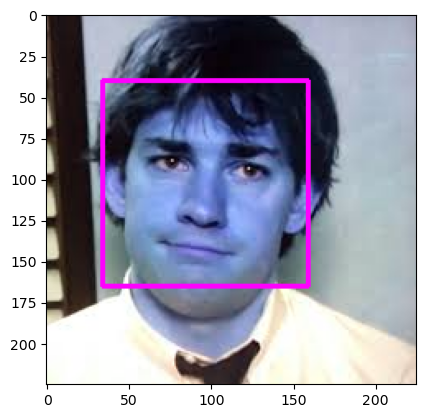

1/1 [==============================] - 0s 13ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Jim/188.png


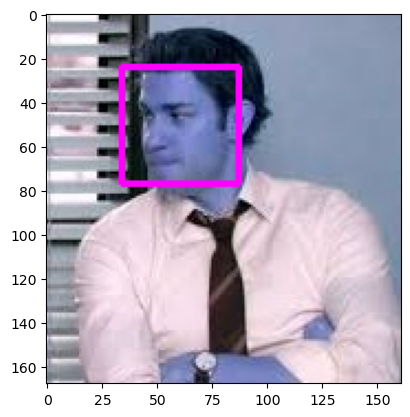

1/1 [==============================] - 0s 19ms/step
[[0. 0. 1. 0. 0. 0.]]
2
Predicted face: Jim

../Data/characters/train/Michael/279 10.25.20 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Michael/38 10.25.20 AM.png


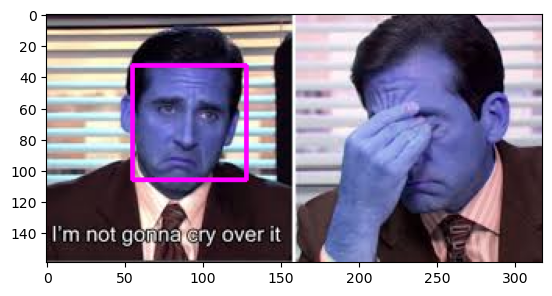

1/1 [==============================] - 0s 15ms/step
[[0. 0. 0. 0. 1. 0.]]
4
Predicted face: Michael

../Data/characters/train/Michael/42 10.25.20 AM.png


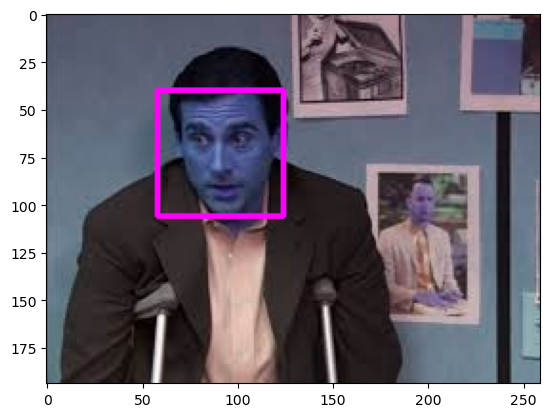

1/1 [==============================] - 0s 13ms/step
[[0. 0. 0. 0. 1. 0.]]
4
Predicted face: Michael

../Data/characters/train/Michael/311 10.25.19 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Michael/178 10.25.20 AM.png


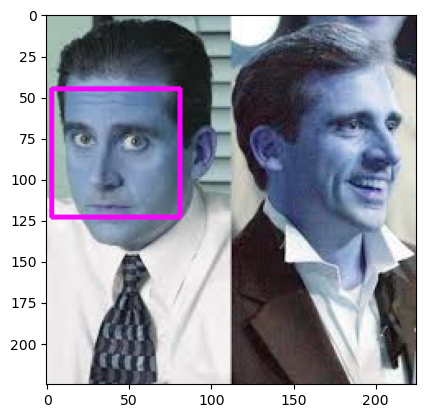

1/1 [==============================] - 0s 13ms/step
[[0. 0. 0. 0. 1. 0.]]
4
Predicted face: Michael

../Data/characters/train/Michael/66 10.25.20 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Michael/393 10.25.19 AM.png


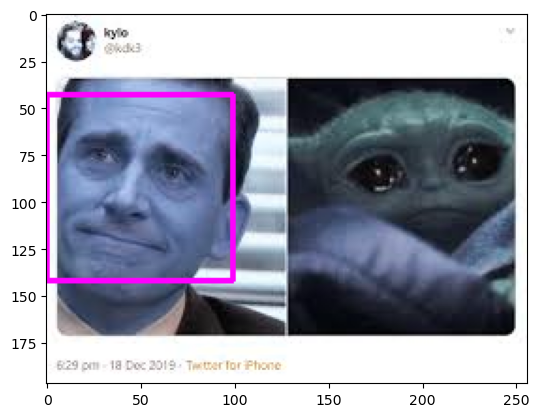

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 0. 1. 0.]]
4
Predicted face: Michael

../Data/characters/train/Michael/308 10.25.19 AM.png


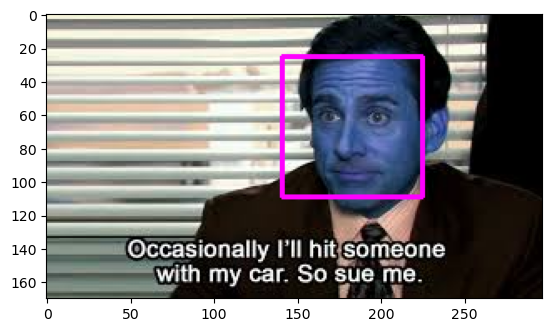

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 0. 1. 0.]]
4
Predicted face: Michael

../Data/characters/train/Michael/180 10.25.20 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Dwight/77.png


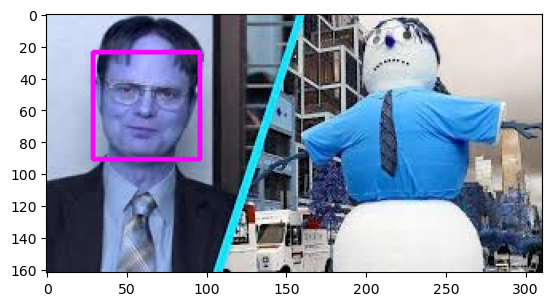

1/1 [==============================] - 0s 13ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Dwight/30 10.20.35 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Dwight/303 10.20.35 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Dwight/96 10.20.35 AM.png


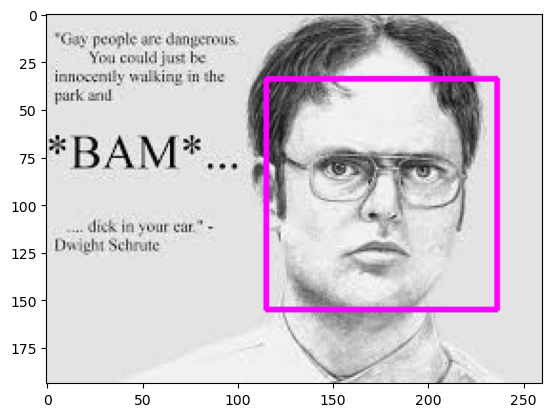

1/1 [==============================] - 0s 14ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Dwight/191 10.20.35 AM.png


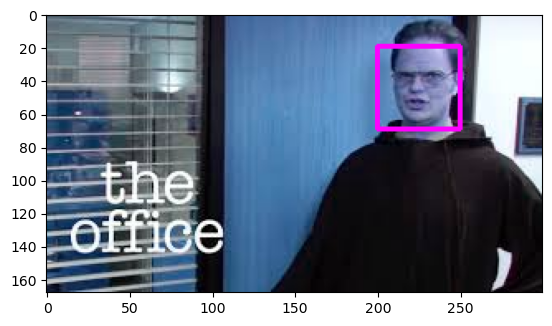

1/1 [==============================] - 0s 13ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Dwight/200.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Dwight/29 10.20.35 AM.png


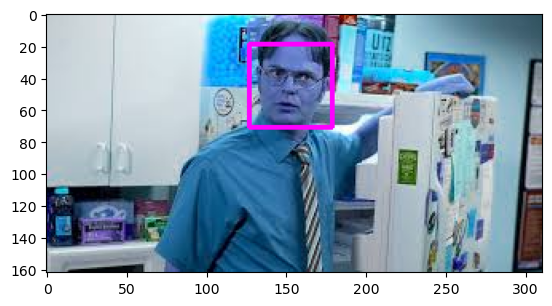

1/1 [==============================] - 0s 13ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Dwight/4 10.20.35 AM.png


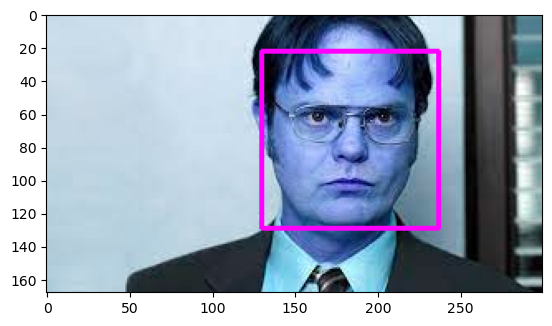

1/1 [==============================] - 0s 16ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Dwight/14 10.20.35 AM.png


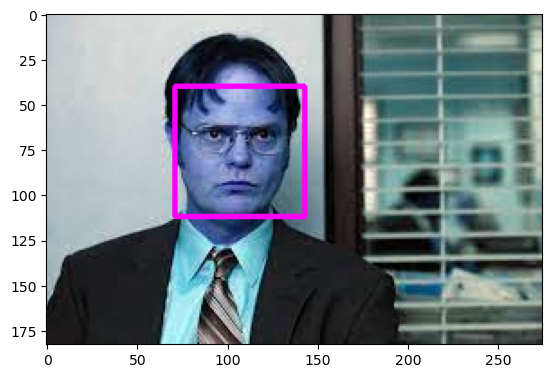

1/1 [==============================] - 0s 14ms/step
[[0. 1. 0. 0. 0. 0.]]
1
Predicted face: Dwight

../Data/characters/train/Pam/78 10.26.58 AM.png


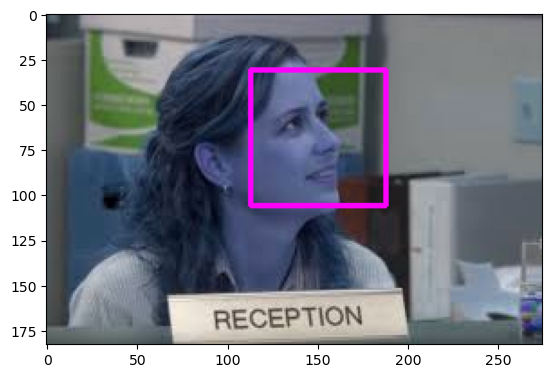

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 0. 0. 1.]]
5
Predicted face: Pam

../Data/characters/train/Pam/105 10.26.58 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Pam/26 10.26.58 AM.png


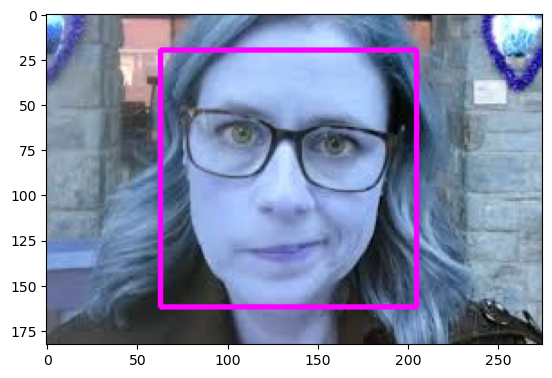

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 0. 0. 1.]]
5
Predicted face: Pam

../Data/characters/train/Pam/187 10.26.58 AM.png


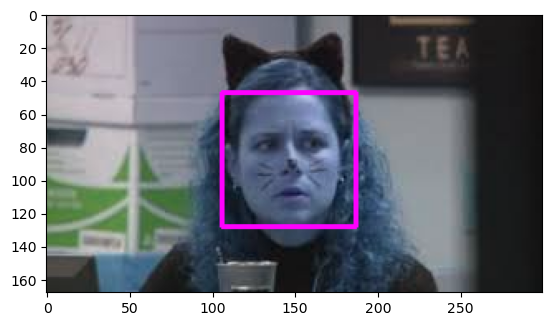

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 0. 0. 1.]]
5
Predicted face: Pam

../Data/characters/train/Pam/80 10.26.58 AM.png


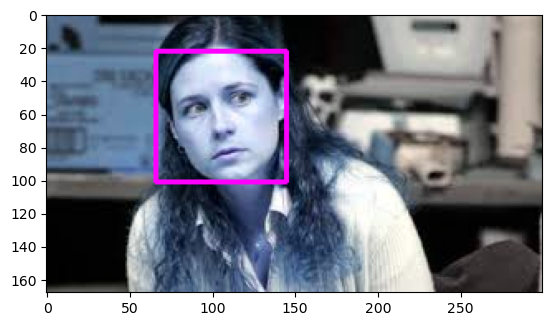

1/1 [==============================] - 0s 15ms/step
[[0. 0. 0. 0. 0. 1.]]
5
Predicted face: Pam

../Data/characters/train/Pam/61 10.26.58 AM.png


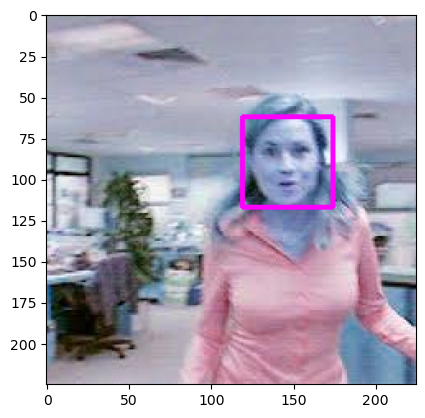

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Pam/113 10.26.58 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Pam/4 10.26.58 AM.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Pam/188 10.26.58 AM.png


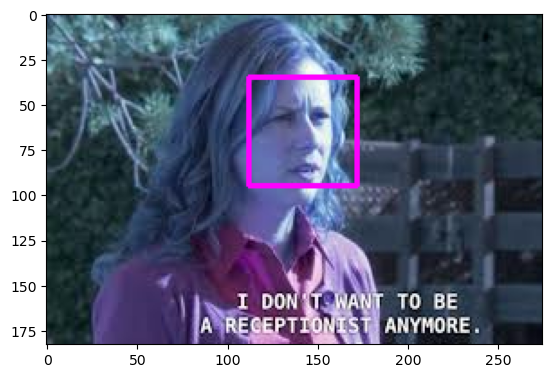

1/1 [==============================] - 0s 17ms/step
[[0. 0. 0. 0. 0. 1.]]
5
Predicted face: Pam

../Data/characters/train/Angela/189.png


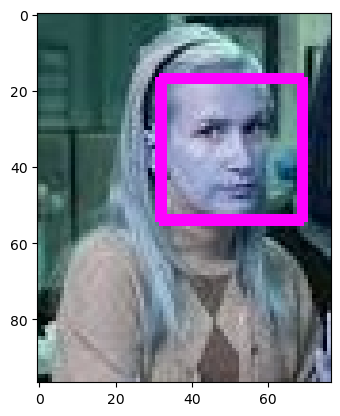

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/63.png


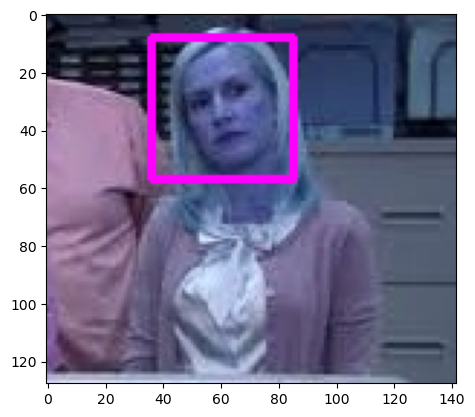

1/1 [==============================] - 0s 13ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/214.png


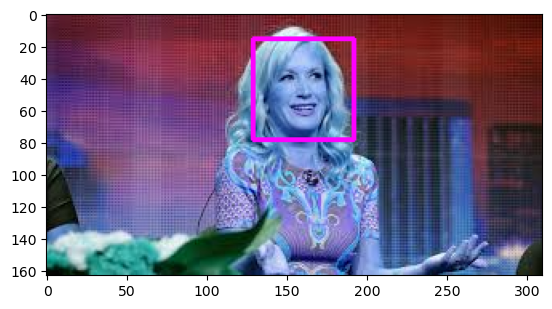

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/215.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Angela/201.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Angela/62.png


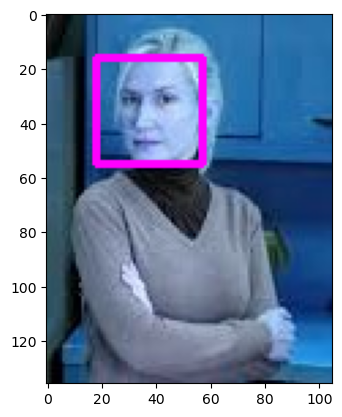

1/1 [==============================] - 0s 18ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/89.png


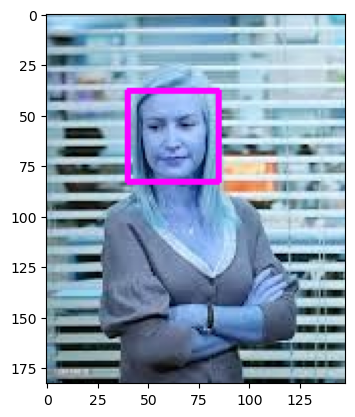

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/60.png


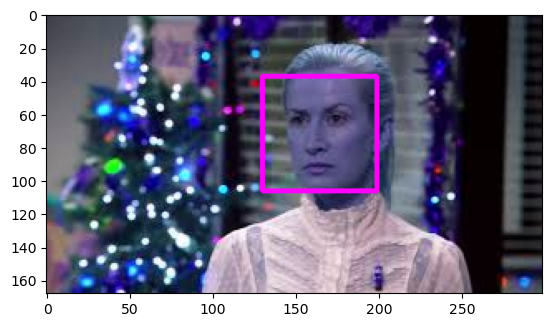

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Angela/48.png


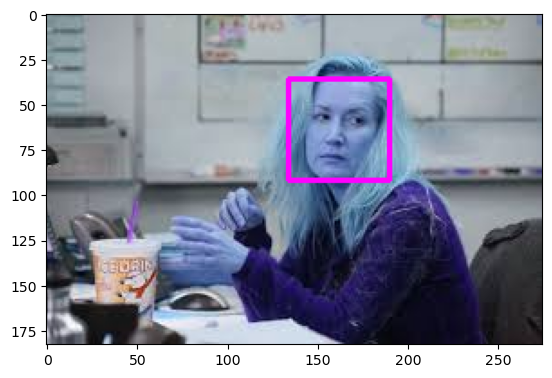

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Kevin/88.png


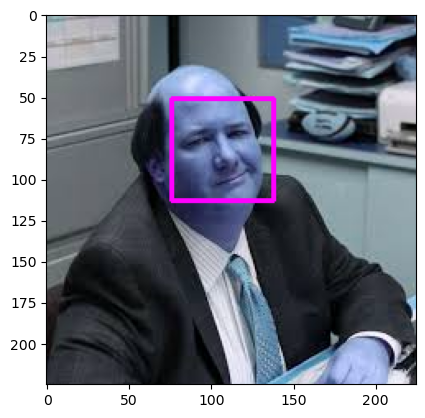

1/1 [==============================] - 0s 14ms/step
[[0. 0. 0. 1. 0. 0.]]
3
Predicted face: Kevin

../Data/characters/train/Kevin/189.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Kevin/77.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Kevin/63.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Kevin/200.png


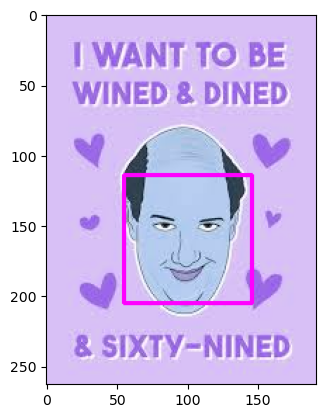

1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Kevin/214.png
---We need exactly 1 face; photo skipped---

../Data/characters/train/Kevin/215.png


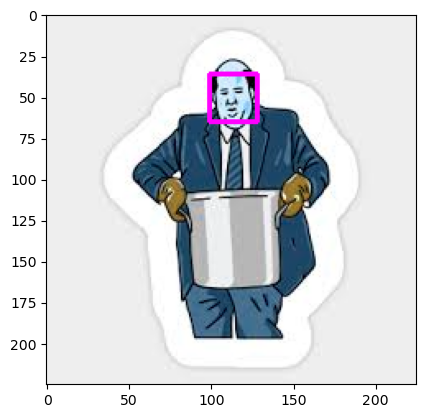

1/1 [==============================] - 0s 16ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Kevin/201.png


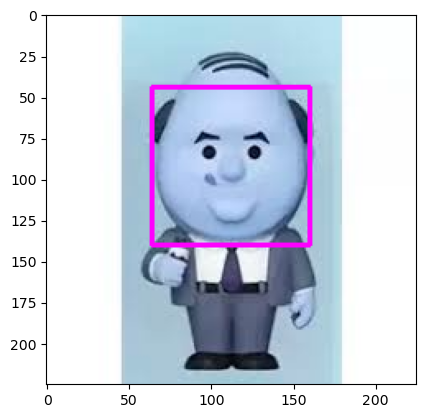

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0. 0. 0. 0.]]
0
Predicted face: Angela

../Data/characters/train/Kevin/188.png
---We need exactly 1 face; photo skipped---



In [21]:
import keras.utils as image


# for detecting faces
facecascade =  cv2.CascadeClassifier(
    'haarcascade_frontalface_default.xml')

#character = 'Angela'

#if character == 'Angela':
#    start = 

test_path = '../Data/characters/train'

for root, _, files in os.walk(test_path):
    for file in files[1:10]:

        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
        # path of the image
        # print(path)
            path = os.path.join(root, file)
            print(path)
        else:
            continue



        label = os.path.basename(root).replace(" ", ".").lower()

        # load the image
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest, 
            scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1: 
            print(f'---We need exactly 1 face; photo skipped---')
            print()
            continue

        for (x_, y_, w, h) in faces:
            # draw the face detected
            face_detect = cv2.rectangle(
                imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
            plt.imshow(face_detect)
            plt.show()

            # resize the detected face to 224x224
            size = (image_width, image_height)
            roi = image_array[y_: y_ + h, x_: x_ + w]
            resized_image = cv2.resize(roi, size)

            # prepare the image for prediction
            x = image.img_to_array(resized_image)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x, version=1)

            # making prediction
            predicted_prob = model.predict(x)
            print(predicted_prob)
            print(predicted_prob[0].argmax())
            print("Predicted face: " + class_list[predicted_prob[0].argmax()])
            print("============================\n")